# Mini Project

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [1]:
import os
import pathlib
from pathlib import Path
import tensorflow as tf
import tensorflow_addons as tfa
import pickle
import numpy as np
import matplotlib.pyplot as plt

2024-03-26 10:05:55.694400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/chihoonlee/opt/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/chihoonlee/opt/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWar

In [2]:
# Load image data and its corresponding labels
from data_merger import merge_data

train_img = merge_data(["data1/train_images1",
            "data2/train_images2",
            "data3/train_images3"])
train_labels = merge_data(["data1/train_labels1",
                    "data2/train_labels2",
                    "data3/train_labels3"])

2024-03-26 10:05:59.979620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Analysis

In [3]:
train_img.shape

(60000, 28, 28)

In [4]:
num_imgs = 12

In [5]:
num_labels = len(np.unique(train_labels))
batch_size = 64

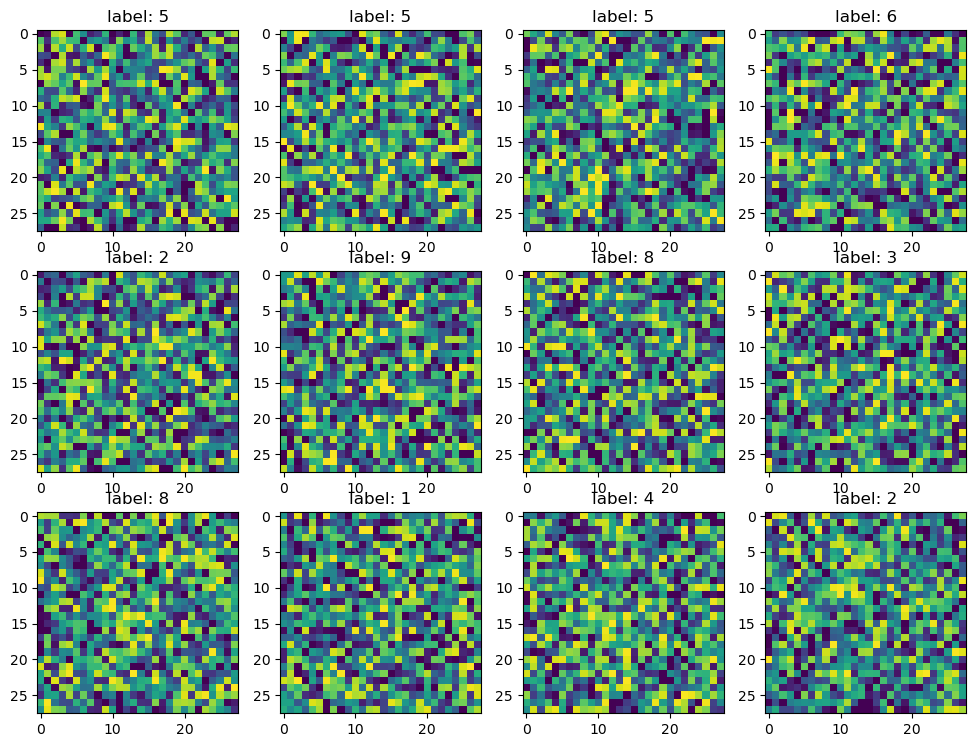

In [7]:
# Visualize Images for Data Analysis
rand_idx = np.random.randint(0, train_img.shape[0], size=num_imgs)
plt.figure(figsize=(12,12))
for j in range(num_imgs):
    ax = plt.subplot((num_imgs // 4) + 1, 4, j+1)
    plt.imshow(train_img[rand_idx[j]])
    ax.set_title(f"label: {train_labels[rand_idx[j]]}")

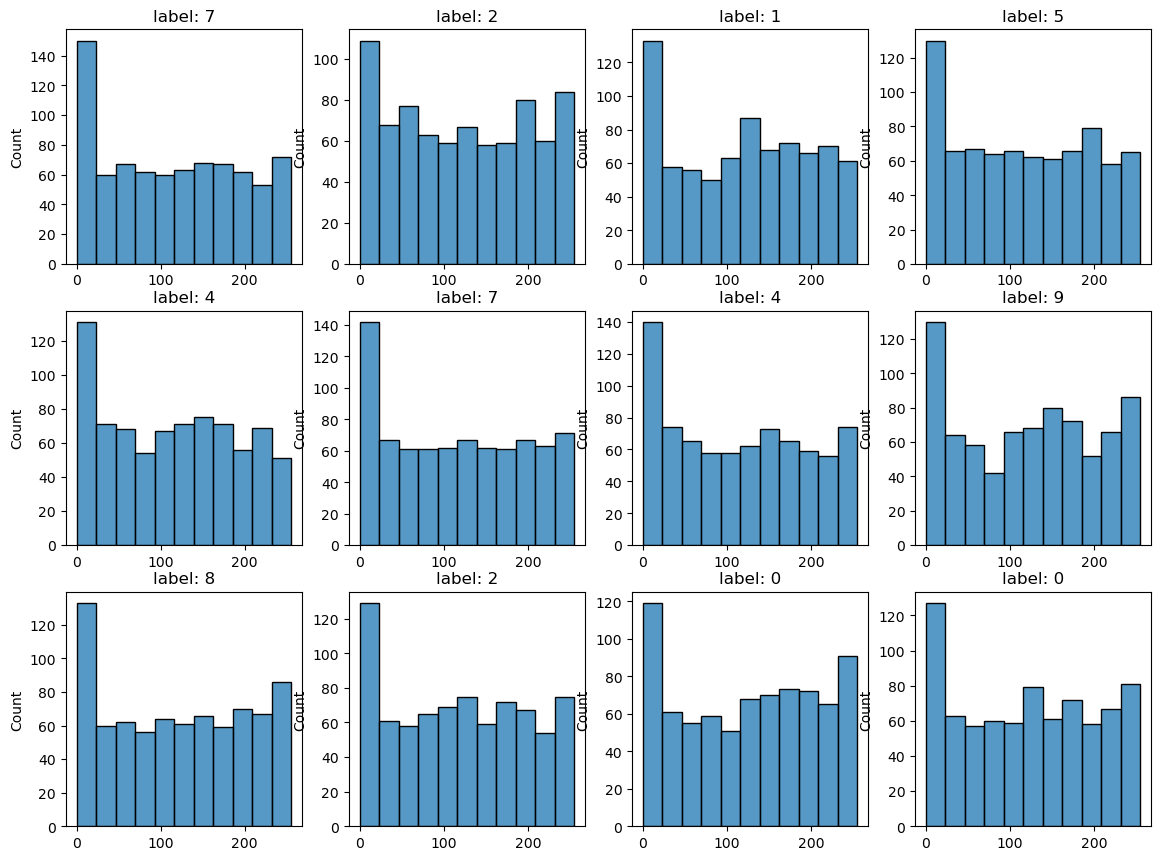

In [8]:
import seaborn as sns

# plot distribution of intensity to analyze the effect of noise
rand_idx = np.random.randint(0, train_img.shape[0], size=num_imgs)
plt.figure(figsize=(14,14))
for j in range(num_imgs):
    ax = plt.subplot((num_imgs // 4) + 1, 4, j+1)
    sns.histplot(train_img[rand_idx[j]].flatten(), ax=ax)
    ax.set_title(f"label: {train_labels[rand_idx[j]]}")

In [9]:
# statistical summary of intensity of images
train_img_float = tf.cast(train_img, 'float')
total_mean = tf.math.reduce_mean(train_img_float, axis=(2,1,0))
total_std = tf.math.reduce_std(train_img_float, axis=(2,1,0))
print(f"average signal mean: {total_mean}, average signal standard deviation: {total_std}")

average signal mean: 118.4206771850586, average signal standard deviation: 79.3892593383789


Observing the signal distribution of randomly selected images from the data, the noise looks like uniformly distributed

## Global parameters

In [10]:
BATCH_SIZE = 64
RANDOM_SEED = 0
LEARNING_RATE = 1e-3
LEARNING_RATE_MIN = 1e-6
EPOCHS = 30

## Data pipeline

In [11]:
train_img = tf.expand_dims(train_img,axis=-1)
print(tf.shape(train_labels))
print(tf.shape(train_img))

tf.Tensor([60000], shape=(1,), dtype=int32)
tf.Tensor([60000    28    28     1], shape=(4,), dtype=int32)


In [12]:
def get_tf_dataset(data_label_pair, **kwargs):
    '''
    form tensorflow batch datasets for train, test, and validation
    param: data_label_pair is a tuple of data and corresponding class labels
    return train, test, and validation datasets in tf batch dataset
    '''
    batch_size = kwargs.get("batch_size", BATCH_SIZE)
    dataset = tf.data.Dataset.from_tensor_slices(tuple(data_label_pair))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    # split data into train, validation, and test
    splitted_datasets = split_train_val_test_tf(
        dataset, dataset_size=tf.data.experimental.cardinality(dataset).numpy())
    # print size of each split
    for dataset, split in zip(splitted_datasets, ["train", "validation", "test"]):
        num_batches = tf.data.experimental.cardinality(dataset).numpy()
        num_img = num_batches*batch_size
        print(f"number of images in {split}: {num_img}")
        print(f"number of batches in {split}: {num_batches}")
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return splitted_datasets

def split_train_val_test_tf(dataset, dataset_size, train_split=0.8, val_split=0.1, test_split=0.1,
                            shuffle=True, **kwargs):
    '''
    split dataset into train, validation, and test data
    param: dataset is a tensorflow dataset
    param: dataset_size is the total number of data in the dataset
    param: train_split is float indicating a split ratio for train dataset
    param: val_split is float indicatinga split ratio for validation dataset
    param: test_split is float indicating a split ratio for test dataset
    param: shuffle is a boolean indicating whether to shuffle data
    return train, test, and validation datasets
    '''
    # Use tensorflow to split data into train + val + test, compatible with tf.data API
    assert (train_split + test_split + val_split) == 1
    
    # get optional parameters
    #shuffle_size = kwargs.get("shuffle_size", 10000)
    buffer_size = kwargs.get("buffer_size", 25000)

    if shuffle:
        # Random shuffling the dataset
        dataset = dataset.shuffle(buffer_size)

    train_size = int(np.ceil(train_split * dataset_size))
    val_size = int(np.ceil(val_split * dataset_size))

    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_size)
    test_data = dataset.skip(train_size).skip(val_size)

    return train_data, val_data, test_data

# Convert to tf_dataset
ds_tuple = get_tf_dataset([train_img, train_labels])
for ds, split in zip(ds_tuple, ["train", "validation", "test"]):
    print(f"{split}: {ds}")

number of images in train: 48000
number of batches in train: 750
number of images in validation: 6016
number of batches in validation: 94
number of images in test: 5952
number of batches in test: 93
train: <TakeDataset element_spec=(TensorSpec(shape=(64, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(64,), dtype=tf.uint8, name=None))>
validation: <TakeDataset element_spec=(TensorSpec(shape=(64, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(64,), dtype=tf.uint8, name=None))>
test: <SkipDataset element_spec=(TensorSpec(shape=(64, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(64,), dtype=tf.uint8, name=None))>


## Optimizer

In [14]:
class WarmUpLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Warmup optimizer"""
    def __init__(self, initial_lr, decay_scheduler, warmup_steps, name, **kwargs):
        super().__init__()
        power = kwargs.get("power", 1.0)  # exponent for polynomial warmup
        name = kwargs.get("name")
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_scheduler = decay_scheduler
        self.name = name

        
    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup
            # if power==1, then linear warmup
            step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            #warmup_percent_done = global_step_float / warmup_steps_float
            #warmup_learning_rate = self.initial_learning_rate * \
            #    tf.math.pow(warmup_percent_done, self.power)
            warmup_lr = self.initial_lr * \
                tf.math.pow(step_float / warmup_steps_float, self.power)
            # warmpup schedule if step < warmup steps. else, decay schedule
            return tf.cond(
                step_float < warmup_steps_float,
                lambda: warmup_lr,
                lambda: self.decay_scheduler(step - self.warmup_steps),
                name=name,
            )

        
    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_scheduler": self.decay_scheduler,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }


In [15]:
# Get parameters for optimizer
num_batches = {}
for ds, split in zip(ds_tuple, ["train", "validation", "test"]):
    num_batches[split] = tf.data.experimental.cardinality(ds).numpy()
steps_per_execution = tf.constant(num_batches['train'], dtype=tf.int64)
#steps_per_epoch = int(steps_per_execution.numpy())
steps_per_epoch = int(steps_per_execution)
validation_steps = num_batches['validation']

lr = LEARNING_RATE
lr_min = LEARNING_RATE_MIN

# Optimizer
warmup_epochs = int(EPOCHS * 0.2)
warmup_steps = int(steps_per_epoch * warmup_epochs)
decay_steps = int(steps_per_epoch * EPOCHS * 0.9)
decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(lr,
                                                            decay_steps, alpha=lr_min)
lr_schedule = WarmUpLRSchedule(initial_lr=lr, decay_scheduler=decay_scheduler,
    warmup_steps=warmup_steps, power=1.0, name="warmUpCosineDecay")
optimizer = tfa.optimizers.AdamW(
    learning_rate=lr_schedule, weight_decay=1e-4)

## Building Model

In [16]:
class FactorizedReduce(tf.keras.layers.Layer):
    """Downsampling layer B x H x W x Cin -> B x H/2 x W/2 x Cout"""
    def __init__(self, num_channel, **kwargs):
        super(FactorizedReduce, self).__init__(**kwargs)
        assert num_channel % 2 == 0
        self.num_channel = num_channel
        self.conv1 = tf.keras.layers.Conv2D(
            num_channel // 4, 1, strides=2, padding="same")
        self.conv2 = tf.keras.layers.Conv2D(
            num_channel // 4, 1, strides=2, padding="same")
        self.conv3 = tf.keras.layers.Conv2D(
            num_channel // 4, 1, strides=2, padding="same")
        self.conv4 = tf.keras.layers.Conv2D(
            num_channel - 3 * (num_channel // 4), 1, strides=2, padding="same")

    def call(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x[:, 1:, 1:, :])
        x3 = self.conv3(x[:, :, 1:, :])
        x4 = self.conv4(x[:, 1:, :, :])
        out = tf.concat([x1, x2, x3, x4], axis=-1)
        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_channel': self.num_channel,
            #'conv1': self.conv1,
            #'conv2': self.conv2,
            #'conv3': self.conv3,
            #'conv4': self.conv4
        })
        return config

In [17]:
class SqueezeAndExcitation(tf.keras.layers.Layer):
    # squeeze and exciation block
    def __init__(self, num_channel, ratio=8, **kwargs):
        # param num_channel: int representing the number of channels
        # param ration: int representing reduction ratio in excitation operations.
        #               original paper discussed 16 achieved good tradeoff between accuracy and complexity
        name = kwargs.get('name')
        self.num_channel = num_channel
        self.ratio = ratio
        super().__init__(name=name)
        # reduce each channel to single value (squeeze)
        self.reduce_avg = tf.keras.layers.GlobalAveragePooling2D()
        # Excitation layers
        self.dense1 = tf.keras.layers.Dense(num_channel // ratio, use_bias=False)
        self.relu = tf.keras.layers.Activation('relu')
        self.dense2 = tf.keras.layers.Dense(num_channel, use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')
    
    
    def call(self, x):
        # param x: a batch of data
        se_out = self.reduce_avg(x)
        se_out = self.dense1(se_out)
        se_out = self.relu(se_out)
        se_out = self.dense2(se_out)
        se_out = self.sigmoid(se_out)
        return tf.keras.layers.multiply([x, se_out])
    
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_channel': self.num_channel,
            'ratio': self.ratio,
        })
        return config


In [18]:
class ResidualBlock(tf.keras.layers.Layer):
    # Residual Network Block
    def __init__(self, num_channel, strides=1, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_channel = num_channel
        self.strides = strides
        self.block = [
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Conv2D(self.num_channel, kernel_size=3, strides=strides,
                                   padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.Activation(tf.keras.activations.gelu),
            tf.keras.layers.Conv2D(self.num_channel, kernel_size=3, strides=1,
                                   padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            SqueezeAndExcitation(self.num_channel),
        ]
        self.residual = tf.keras.layers.Conv2D(self.num_channel, kernel_size=1, strides=1,
                                   padding="same") \
                                   if strides == 1 \
                                   else FactorizedReduce(self.num_channel)

    def call(self, x):
        x_residual = self.residual(x)
        for layer in self.block:
            x = layer(x)
        output = x + x_residual
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_channel': self.num_channel,
            'strides': self.strides
        })
        return config


In [19]:
class MBConv(tf.keras.layers.Layer):
    # Mobile Net Convolution block
    def __init__(self, num_channel, strides=1, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_channel = num_channel
        self.strides = strides

        self.block = [
            tf.keras.layers.Conv2D(self.num_channel, kernel_size=1, strides=strides,
                                   padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.SeparableConv2D(self.num_channel*4, kernel_size=5, strides=1,
                                            padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            tf.keras.layers.Activation(tf.keras.activations.gelu),
            tf.keras.layers.Conv2D(self.num_channel, kernel_size=1, strides=1,
                                   padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
            SqueezeAndExcitation(self.num_channel),
        ]
        self.residual = tf.keras.layers.Conv2D(self.num_channel, kernel_size=1, strides=strides,
                                   padding="same", kernel_initializer=tf.keras.initializers.HeNormal())
    def call(self, x):
        x_residual = self.residual(x)
        for layer in self.block:
            x = layer(x)
        output = x + x_residual
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_channel': self.num_channel,
            'strides': self.strides
        })
        return config


In [20]:
x_input = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Lambda(lambda x: x / 255.)(x_input)
x = tf.keras.layers.Conv2D(32, kernel_size=3, strides=(
        1, 1), padding="same", kernel_initializer=tf.keras.initializers.HeNormal())(x)
x = tf.keras.layers.Conv2D(32, kernel_size=5, strides=(
        1, 1), padding="same", kernel_initializer=tf.keras.initializers.HeNormal())(x)
x = tf.keras.layers.Activation(tf.keras.activations.gelu)(x)
x = ResidualBlock(64, strides=2)(x)
x = ResidualBlock(256, strides=2)(x)
x = MBConv(256, strides=2)(x)
x = MBConv(512, strides=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs=x_input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 residual_block (ResidualBlo  (None, 14, 14, 64)       58624     
 ck)                                                             
                                                             

## Model Compile

In [23]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ],
    steps_per_execution=steps_per_execution
)

## Training Model

In [24]:
train_data, val_data, test_data = ds_tuple

checkpoint_filepath = "noisy_image_classifier.h5"
callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                checkpoint_filepath,
                monitor="val_loss",
                mode='min',
                save_best_only=True,
                save_weights_only=False,
            ),
        ]

history = model.fit(
            train_data,
            epochs=EPOCHS,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_data,
            validation_freq=1,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1,
        )

Epoch 1/30
750/750 [==============================] - ETA: 0s - loss: 3.1279 - accuracy: 0.1430

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 355s 473ms/step - loss: 3.1279 - accuracy: 0.1430 - val_loss: 2.0569 - val_accuracy: 0.2711
Epoch 2/30
750/750 [==============================] - ETA: 0s - loss: 2.0131 - accuracy: 0.2873

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 352s 469ms/step - loss: 2.0131 - accuracy: 0.2873 - val_loss: 1.9388 - val_accuracy: 0.3157
Epoch 3/30
750/750 [==============================] - ETA: 0s - loss: 1.9418 - accuracy: 0.3134

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 343s 458ms/step - loss: 1.9418 - accuracy: 0.3134 - val_loss: 1.9125 - val_accuracy: 0.3321
Epoch 4/30
750/750 [==============================] - ETA: 0s - loss: 1.7612 - accuracy: 0.3860

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 341s 455ms/step - loss: 1.7612 - accuracy: 0.3860 - val_loss: 1.5149 - val_accuracy: 0.4786
Epoch 5/30
750/750 [==============================] - ETA: 0s - loss: 1.5220 - accuracy: 0.4761

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 341s 455ms/step - loss: 1.5220 - accuracy: 0.4761 - val_loss: 1.4076 - val_accuracy: 0.5196
Epoch 6/30
750/750 [==============================] - ETA: 0s - loss: 1.4501 - accuracy: 0.5040

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 342s 456ms/step - loss: 1.4501 - accuracy: 0.5040 - val_loss: 1.4018 - val_accuracy: 0.5143
Epoch 7/30
750/750 [==============================] - ETA: 0s - loss: 1.4137 - accuracy: 0.5132

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 341s 455ms/step - loss: 1.4137 - accuracy: 0.5132 - val_loss: 1.3074 - val_accuracy: 0.5477
Epoch 8/30
750/750 [==============================] - ETA: 0s - loss: 1.3624 - accuracy: 0.5340

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 341s 454ms/step - loss: 1.3624 - accuracy: 0.5340 - val_loss: 1.2183 - val_accuracy: 0.5866
Epoch 9/30
750/750 [==============================] - 338s 450ms/step - loss: 1.3145 - accuracy: 0.5518 - val_loss: 1.3222 - val_accuracy: 0.5487
Epoch 10/30
750/750 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.5686

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 341s 454ms/step - loss: 1.2603 - accuracy: 0.5686 - val_loss: 1.1494 - val_accuracy: 0.6149
Epoch 11/30
750/750 [==============================] - ETA: 0s - loss: 1.2078 - accuracy: 0.5897

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 342s 456ms/step - loss: 1.2078 - accuracy: 0.5897 - val_loss: 1.0216 - val_accuracy: 0.6592
Epoch 12/30
750/750 [==============================] - 341s 454ms/step - loss: 1.1504 - accuracy: 0.6063 - val_loss: 1.0280 - val_accuracy: 0.6528
Epoch 13/30
750/750 [==============================] - ETA: 0s - loss: 1.0747 - accuracy: 0.6323

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 341s 455ms/step - loss: 1.0747 - accuracy: 0.6323 - val_loss: 0.9561 - val_accuracy: 0.6840
Epoch 14/30
750/750 [==============================] - ETA: 0s - loss: 0.9916 - accuracy: 0.6607

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 342s 455ms/step - loss: 0.9916 - accuracy: 0.6607 - val_loss: 0.8733 - val_accuracy: 0.7048
Epoch 15/30
750/750 [==============================] - ETA: 0s - loss: 0.9140 - accuracy: 0.6862

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 368s 490ms/step - loss: 0.9140 - accuracy: 0.6862 - val_loss: 0.7065 - val_accuracy: 0.7729
Epoch 16/30
750/750 [==============================] - ETA: 0s - loss: 0.8137 - accuracy: 0.7220

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 364s 485ms/step - loss: 0.8137 - accuracy: 0.7220 - val_loss: 0.6297 - val_accuracy: 0.7874
Epoch 17/30
750/750 [==============================] - ETA: 0s - loss: 0.7191 - accuracy: 0.7531

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 366s 488ms/step - loss: 0.7191 - accuracy: 0.7531 - val_loss: 0.5357 - val_accuracy: 0.8240
Epoch 18/30
750/750 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.7914

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 363s 484ms/step - loss: 0.6120 - accuracy: 0.7914 - val_loss: 0.3793 - val_accuracy: 0.8748
Epoch 19/30
750/750 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.8207

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 362s 483ms/step - loss: 0.5226 - accuracy: 0.8207 - val_loss: 0.3589 - val_accuracy: 0.8888
Epoch 20/30
750/750 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8507

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 364s 486ms/step - loss: 0.4350 - accuracy: 0.8507 - val_loss: 0.2547 - val_accuracy: 0.9174
Epoch 21/30
750/750 [==============================] - 369s 492ms/step - loss: 0.3459 - accuracy: 0.8802 - val_loss: 0.3157 - val_accuracy: 0.8951
Epoch 22/30
750/750 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8989

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 376s 502ms/step - loss: 0.2885 - accuracy: 0.8989 - val_loss: 0.1584 - val_accuracy: 0.9496
Epoch 23/30
750/750 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9214

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 382s 509ms/step - loss: 0.2278 - accuracy: 0.9214 - val_loss: 0.1418 - val_accuracy: 0.9555
Epoch 24/30
750/750 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9358

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 386s 514ms/step - loss: 0.1883 - accuracy: 0.9358 - val_loss: 0.1253 - val_accuracy: 0.9641
Epoch 25/30
750/750 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9461

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 395s 527ms/step - loss: 0.1585 - accuracy: 0.9461 - val_loss: 0.0948 - val_accuracy: 0.9704
Epoch 26/30
750/750 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9549

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 413s 551ms/step - loss: 0.1342 - accuracy: 0.9549 - val_loss: 0.0865 - val_accuracy: 0.9734
Epoch 27/30
750/750 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9575

INFO:tensorflow:Assets written to: noisy_image_classifier/assets


INFO:tensorflow:Assets written to: noisy_image_classifier/assets


750/750 [==============================] - 418s 557ms/step - loss: 0.1282 - accuracy: 0.9575 - val_loss: 0.0663 - val_accuracy: 0.9847
Epoch 28/30
750/750 [==============================] - 414s 552ms/step - loss: 0.1301 - accuracy: 0.9589 - val_loss: 0.1278 - val_accuracy: 0.9611
Epoch 29/30
750/750 [==============================] - 387s 516ms/step - loss: 0.1533 - accuracy: 0.9504 - val_loss: 0.1327 - val_accuracy: 0.9712
Epoch 30/30
750/750 [==============================] - 357s 476ms/step - loss: 0.2116 - accuracy: 0.9318 - val_loss: 0.2221 - val_accuracy: 0.9428


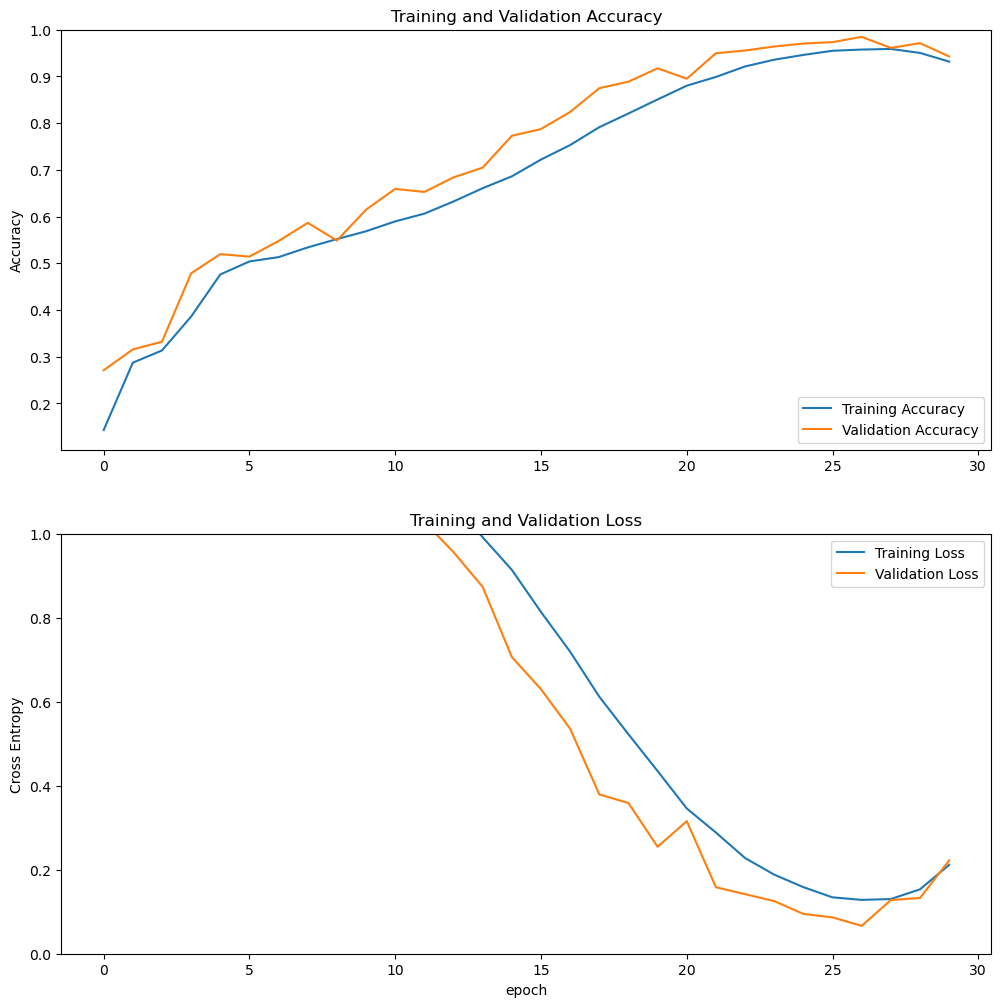

In [25]:
# Plot training process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
# Load the best model
model = tf.keras.models.load_model("noisy_image_classifier.h5", custom_objects={
                                      "ResidualBlock": ResidualBlock,
                                      "MBConv": MBConv,
                                    "WarmUpLRSchedule": WarmUpLRSchedule
                                  })
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ],
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 residual_block (ResidualBlo  (None, 14, 14, 64)       58624     
 ck)                                                             
                                                             

In [34]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"test loss: {test_loss}")
print(f'Test accuracy: {test_accuracy}')

93/93 [==============================] - 11s 94ms/step - loss: 0.0759 - accuracy: 0.9798
test loss: 0.07586465030908585
Test accuracy: 0.9798387289047241
